# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 17:00 - loss: 0.6927

  28/1875 [..............................] - ETA: 3s - loss: 0.5495   

  57/1875 [..............................] - ETA: 3s - loss: 0.4678

  88/1875 [>.............................] - ETA: 3s - loss: 0.4226

 122/1875 [>.............................] - ETA: 2s - loss: 0.3923

 152/1875 [=>............................] - ETA: 2s - loss: 0.3734

 186/1875 [=>............................] - ETA: 2s - loss: 0.3567

 221/1875 [==>...........................] - ETA: 2s - loss: 0.3430

 256/1875 [===>..........................] - ETA: 2s - loss: 0.3315

 290/1875 [===>..........................] - ETA: 2s - loss: 0.3220

 323/1875 [====>.........................] - ETA: 2s - loss: 0.3139

 352/1875 [====>.........................] - ETA: 2s - loss: 0.3076

 383/1875 [=====>........................] - ETA: 2s - loss: 0.3015

 418/1875 [=====>........................] - ETA: 2s - loss: 0.2952

 446/1875 [======>.......................] - ETA: 2s - loss: 0.2906

 471/1875 [======>.......................] - ETA: 2s - loss: 0.2868

 506/1875 [=======>......................] - ETA: 2s - loss: 0.2818

 538/1875 [=======>......................] - ETA: 2s - loss: 0.2776

 571/1875 [========>.....................] - ETA: 2s - loss: 0.2736

 606/1875 [========>.....................] - ETA: 2s - loss: 0.2696

 639/1875 [=========>....................] - ETA: 1s - loss: 0.2661

 667/1875 [=========>....................] - ETA: 1s - loss: 0.2633

 694/1875 [==========>...................] - ETA: 1s - loss: 0.2607

 727/1875 [==========>...................] - ETA: 1s - loss: 0.2577

 755/1875 [===========>..................] - ETA: 1s - loss: 0.2552

 782/1875 [===========>..................] - ETA: 1s - loss: 0.2530

 814/1875 [============>.................] - ETA: 1s - loss: 0.2505

 843/1875 [============>.................] - ETA: 1s - loss: 0.2483

 872/1875 [============>.................] - ETA: 1s - loss: 0.2462

 904/1875 [=============>................] - ETA: 1s - loss: 0.2439

 938/1875 [==============>...............] - ETA: 1s - loss: 0.2416

 970/1875 [==============>...............] - ETA: 1s - loss: 0.2396

1002/1875 [===============>..............] - ETA: 1s - loss: 0.2376

1033/1875 [===============>..............] - ETA: 1s - loss: 0.2358

1066/1875 [================>.............] - ETA: 1s - loss: 0.2339

1100/1875 [================>.............] - ETA: 1s - loss: 0.2320

1129/1875 [=================>............] - ETA: 1s - loss: 0.2305

1161/1875 [=================>............] - ETA: 1s - loss: 0.2289

1196/1875 [==================>...........] - ETA: 1s - loss: 0.2271

1231/1875 [==================>...........] - ETA: 1s - loss: 0.2254

1266/1875 [===================>..........] - ETA: 0s - loss: 0.2238

1299/1875 [===================>..........] - ETA: 0s - loss: 0.2223

1331/1875 [====================>.........] - ETA: 0s - loss: 0.2209

1357/1875 [====================>.........] - ETA: 0s - loss: 0.2198

1385/1875 [=====================>........] - ETA: 0s - loss: 0.2187

1417/1875 [=====================>........] - ETA: 0s - loss: 0.2174

1452/1875 [======================>.......] - ETA: 0s - loss: 0.2160

1482/1875 [======================>.......] - ETA: 0s - loss: 0.2149

1511/1875 [=======================>......] - ETA: 0s - loss: 0.2138

1546/1875 [=======================>......] - ETA: 0s - loss: 0.2125

1569/1875 [========================>.....] - ETA: 0s - loss: 0.2117

1598/1875 [========================>.....] - ETA: 0s - loss: 0.2107

1624/1875 [========================>.....] - ETA: 0s - loss: 0.2098

1647/1875 [=========================>....] - ETA: 0s - loss: 0.2091

1667/1875 [=========================>....] - ETA: 0s - loss: 0.2084

1690/1875 [==========================>...] - ETA: 0s - loss: 0.2077

1714/1875 [==========================>...] - ETA: 0s - loss: 0.2069

1736/1875 [==========================>...] - ETA: 0s - loss: 0.2062

1762/1875 [===========================>..] - ETA: 0s - loss: 0.2054

1784/1875 [===========================>..] - ETA: 0s - loss: 0.2048

1813/1875 [============================>.] - ETA: 0s - loss: 0.2039

1842/1875 [============================>.] - ETA: 0s - loss: 0.2031

1868/1875 [============================>.] - ETA: 0s - loss: 0.2023

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2021


Epoch 2/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1164

  32/1875 [..............................] - ETA: 2s - loss: 0.1105

  59/1875 [..............................] - ETA: 3s - loss: 0.1099

  88/1875 [>.............................] - ETA: 3s - loss: 0.1095

 116/1875 [>.............................] - ETA: 3s - loss: 0.1093

 143/1875 [=>............................] - ETA: 3s - loss: 0.1091

 173/1875 [=>............................] - ETA: 3s - loss: 0.1089

 201/1875 [==>...........................] - ETA: 2s - loss: 0.1088

 233/1875 [==>...........................] - ETA: 2s - loss: 0.1086

 269/1875 [===>..........................] - ETA: 2s - loss: 0.1085

 299/1875 [===>..........................] - ETA: 2s - loss: 0.1084

 330/1875 [====>.........................] - ETA: 2s - loss: 0.1083

 365/1875 [====>.........................] - ETA: 2s - loss: 0.1082

 401/1875 [=====>........................] - ETA: 2s - loss: 0.1081

 438/1875 [======>.......................] - ETA: 2s - loss: 0.1080

 474/1875 [======>.......................] - ETA: 2s - loss: 0.1079

 511/1875 [=======>......................] - ETA: 2s - loss: 0.1078

 542/1875 [=======>......................] - ETA: 2s - loss: 0.1077

 572/1875 [========>.....................] - ETA: 2s - loss: 0.1076

 606/1875 [========>.....................] - ETA: 2s - loss: 0.1076

 640/1875 [=========>....................] - ETA: 1s - loss: 0.1075

 673/1875 [=========>....................] - ETA: 1s - loss: 0.1074

 709/1875 [==========>...................] - ETA: 1s - loss: 0.1074

 741/1875 [==========>...................] - ETA: 1s - loss: 0.1073

 770/1875 [===========>..................] - ETA: 1s - loss: 0.1072

 799/1875 [===========>..................] - ETA: 1s - loss: 0.1072

 828/1875 [============>.................] - ETA: 1s - loss: 0.1071

 854/1875 [============>.................] - ETA: 1s - loss: 0.1071

 885/1875 [=============>................] - ETA: 1s - loss: 0.1070

 914/1875 [=============>................] - ETA: 1s - loss: 0.1069

 941/1875 [==============>...............] - ETA: 1s - loss: 0.1069

 970/1875 [==============>...............] - ETA: 1s - loss: 0.1068

1005/1875 [===============>..............] - ETA: 1s - loss: 0.1068

1040/1875 [===============>..............] - ETA: 1s - loss: 0.1067

1073/1875 [================>.............] - ETA: 1s - loss: 0.1066

1106/1875 [================>.............] - ETA: 1s - loss: 0.1066

1141/1875 [=================>............] - ETA: 1s - loss: 0.1065

1173/1875 [=================>............] - ETA: 1s - loss: 0.1065

1204/1875 [==================>...........] - ETA: 1s - loss: 0.1064

1239/1875 [==================>...........] - ETA: 1s - loss: 0.1063

1267/1875 [===================>..........] - ETA: 0s - loss: 0.1063

1294/1875 [===================>..........] - ETA: 0s - loss: 0.1062

1315/1875 [====================>.........] - ETA: 0s - loss: 0.1062

1340/1875 [====================>.........] - ETA: 0s - loss: 0.1062

1376/1875 [=====================>........] - ETA: 0s - loss: 0.1061

1410/1875 [=====================>........] - ETA: 0s - loss: 0.1060

1446/1875 [======================>.......] - ETA: 0s - loss: 0.1060

1483/1875 [======================>.......] - ETA: 0s - loss: 0.1059

1519/1875 [=======================>......] - ETA: 0s - loss: 0.1059

1556/1875 [=======================>......] - ETA: 0s - loss: 0.1058

1594/1875 [========================>.....] - ETA: 0s - loss: 0.1057

1629/1875 [=========================>....] - ETA: 0s - loss: 0.1057

1665/1875 [=========================>....] - ETA: 0s - loss: 0.1056

1701/1875 [==========================>...] - ETA: 0s - loss: 0.1056

1737/1875 [==========================>...] - ETA: 0s - loss: 0.1055

1769/1875 [===========================>..] - ETA: 0s - loss: 0.1055

1801/1875 [===========================>..] - ETA: 0s - loss: 0.1054

1836/1875 [============================>.] - ETA: 0s - loss: 0.1054

1869/1875 [============================>.] - ETA: 0s - loss: 0.1053

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1053


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.1048

  32/1875 [..............................] - ETA: 3s - loss: 0.0981

  67/1875 [>.............................] - ETA: 2s - loss: 0.0976

  99/1875 [>.............................] - ETA: 2s - loss: 0.0977

 136/1875 [=>............................] - ETA: 2s - loss: 0.0978

 171/1875 [=>............................] - ETA: 2s - loss: 0.0978

 204/1875 [==>...........................] - ETA: 2s - loss: 0.0979

 240/1875 [==>...........................] - ETA: 2s - loss: 0.0980

 275/1875 [===>..........................] - ETA: 2s - loss: 0.0980

 311/1875 [===>..........................] - ETA: 2s - loss: 0.0980

 339/1875 [====>.........................] - ETA: 2s - loss: 0.0981

 374/1875 [====>.........................] - ETA: 2s - loss: 0.0981

 409/1875 [=====>........................] - ETA: 2s - loss: 0.0981

 446/1875 [======>.......................] - ETA: 2s - loss: 0.0981

 483/1875 [======>.......................] - ETA: 2s - loss: 0.0981

 519/1875 [=======>......................] - ETA: 1s - loss: 0.0981

 554/1875 [=======>......................] - ETA: 1s - loss: 0.0981

 591/1875 [========>.....................] - ETA: 1s - loss: 0.0980

 625/1875 [=========>....................] - ETA: 1s - loss: 0.0980

 661/1875 [=========>....................] - ETA: 1s - loss: 0.0980

 698/1875 [==========>...................] - ETA: 1s - loss: 0.0980

 733/1875 [==========>...................] - ETA: 1s - loss: 0.0980

 768/1875 [===========>..................] - ETA: 1s - loss: 0.0980

 802/1875 [===========>..................] - ETA: 1s - loss: 0.0980

 836/1875 [============>.................] - ETA: 1s - loss: 0.0980

 872/1875 [============>.................] - ETA: 1s - loss: 0.0980

 907/1875 [=============>................] - ETA: 1s - loss: 0.0980

 943/1875 [==============>...............] - ETA: 1s - loss: 0.0980

 981/1875 [==============>...............] - ETA: 1s - loss: 0.0980

1018/1875 [===============>..............] - ETA: 1s - loss: 0.0979

1046/1875 [===============>..............] - ETA: 1s - loss: 0.0979

1082/1875 [================>.............] - ETA: 1s - loss: 0.0979

1117/1875 [================>.............] - ETA: 1s - loss: 0.0979

1154/1875 [=================>............] - ETA: 1s - loss: 0.0979

1189/1875 [==================>...........] - ETA: 0s - loss: 0.0979

1224/1875 [==================>...........] - ETA: 0s - loss: 0.0979

1260/1875 [===================>..........] - ETA: 0s - loss: 0.0979

1295/1875 [===================>..........] - ETA: 0s - loss: 0.0979

1330/1875 [====================>.........] - ETA: 0s - loss: 0.0979

1363/1875 [====================>.........] - ETA: 0s - loss: 0.0979

1401/1875 [=====================>........] - ETA: 0s - loss: 0.0979

1437/1875 [=====================>........] - ETA: 0s - loss: 0.0979

1475/1875 [======================>.......] - ETA: 0s - loss: 0.0978

1512/1875 [=======================>......] - ETA: 0s - loss: 0.0978

1550/1875 [=======================>......] - ETA: 0s - loss: 0.0978

1588/1875 [========================>.....] - ETA: 0s - loss: 0.0978

1626/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1665/1875 [=========================>....] - ETA: 0s - loss: 0.0978

1703/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1740/1875 [==========================>...] - ETA: 0s - loss: 0.0978

1778/1875 [===========================>..] - ETA: 0s - loss: 0.0978

1815/1875 [============================>.] - ETA: 0s - loss: 0.0978

1847/1875 [============================>.] - ETA: 0s - loss: 0.0978

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0978


Epoch 4/5
   1/1875 [..............................] - ETA: 4s - loss: 0.0969

  38/1875 [..............................] - ETA: 2s - loss: 0.0966

  75/1875 [>.............................] - ETA: 2s - loss: 0.0966

 110/1875 [>.............................] - ETA: 2s - loss: 0.0964

 145/1875 [=>............................] - ETA: 2s - loss: 0.0964

 180/1875 [=>............................] - ETA: 2s - loss: 0.0964

 216/1875 [==>...........................] - ETA: 2s - loss: 0.0963

 243/1875 [==>...........................] - ETA: 2s - loss: 0.0963

 278/1875 [===>..........................] - ETA: 2s - loss: 0.0962

 313/1875 [====>.........................] - ETA: 2s - loss: 0.0962

 347/1875 [====>.........................] - ETA: 2s - loss: 0.0962

 381/1875 [=====>........................] - ETA: 2s - loss: 0.0962

 407/1875 [=====>........................] - ETA: 2s - loss: 0.0962

 440/1875 [======>.......................] - ETA: 2s - loss: 0.0962

 474/1875 [======>.......................] - ETA: 2s - loss: 0.0962

 510/1875 [=======>......................] - ETA: 2s - loss: 0.0962

 546/1875 [=======>......................] - ETA: 1s - loss: 0.0962

 584/1875 [========>.....................] - ETA: 1s - loss: 0.0962

 622/1875 [========>.....................] - ETA: 1s - loss: 0.0962

 659/1875 [=========>....................] - ETA: 1s - loss: 0.0962

 697/1875 [==========>...................] - ETA: 1s - loss: 0.0962

 735/1875 [==========>...................] - ETA: 1s - loss: 0.0962

 773/1875 [===========>..................] - ETA: 1s - loss: 0.0962

 805/1875 [===========>..................] - ETA: 1s - loss: 0.0962

 841/1875 [============>.................] - ETA: 1s - loss: 0.0962

 878/1875 [=============>................] - ETA: 1s - loss: 0.0962

 914/1875 [=============>................] - ETA: 1s - loss: 0.0961

 950/1875 [==============>...............] - ETA: 1s - loss: 0.0961

 985/1875 [==============>...............] - ETA: 1s - loss: 0.0961

1022/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1059/1875 [===============>..............] - ETA: 1s - loss: 0.0961

1091/1875 [================>.............] - ETA: 1s - loss: 0.0961

1127/1875 [=================>............] - ETA: 1s - loss: 0.0961

1161/1875 [=================>............] - ETA: 1s - loss: 0.0961

1197/1875 [==================>...........] - ETA: 0s - loss: 0.0961

1232/1875 [==================>...........] - ETA: 0s - loss: 0.0961

1267/1875 [===================>..........] - ETA: 0s - loss: 0.0961

1291/1875 [===================>..........] - ETA: 0s - loss: 0.0961

1323/1875 [====================>.........] - ETA: 0s - loss: 0.0961

1360/1875 [====================>.........] - ETA: 0s - loss: 0.0961

1396/1875 [=====================>........] - ETA: 0s - loss: 0.0961

1431/1875 [=====================>........] - ETA: 0s - loss: 0.0961

1468/1875 [======================>.......] - ETA: 0s - loss: 0.0961

1503/1875 [=======================>......] - ETA: 0s - loss: 0.0961

1538/1875 [=======================>......] - ETA: 0s - loss: 0.0961

1574/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1609/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1643/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1676/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1710/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1744/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1780/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1816/1875 [============================>.] - ETA: 0s - loss: 0.0961

1853/1875 [============================>.] - ETA: 0s - loss: 0.0961

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0960


Epoch 5/5
   1/1875 [..............................] - ETA: 2s - loss: 0.0894

  37/1875 [..............................] - ETA: 2s - loss: 0.0937

  74/1875 [>.............................] - ETA: 2s - loss: 0.0944

 113/1875 [>.............................] - ETA: 2s - loss: 0.0947

 151/1875 [=>............................] - ETA: 2s - loss: 0.0948

 188/1875 [==>...........................] - ETA: 2s - loss: 0.0949

 227/1875 [==>...........................] - ETA: 2s - loss: 0.0949

 266/1875 [===>..........................] - ETA: 2s - loss: 0.0949

 305/1875 [===>..........................] - ETA: 2s - loss: 0.0949

 342/1875 [====>.........................] - ETA: 2s - loss: 0.0950

 372/1875 [====>.........................] - ETA: 2s - loss: 0.0950

 408/1875 [=====>........................] - ETA: 2s - loss: 0.0950

 445/1875 [======>.......................] - ETA: 1s - loss: 0.0950

 482/1875 [======>.......................] - ETA: 1s - loss: 0.0951

 515/1875 [=======>......................] - ETA: 1s - loss: 0.0951

 549/1875 [=======>......................] - ETA: 1s - loss: 0.0951

 585/1875 [========>.....................] - ETA: 1s - loss: 0.0951

 621/1875 [========>.....................] - ETA: 1s - loss: 0.0951

 656/1875 [=========>....................] - ETA: 1s - loss: 0.0951

 693/1875 [==========>...................] - ETA: 1s - loss: 0.0952

 728/1875 [==========>...................] - ETA: 1s - loss: 0.0952

 765/1875 [===========>..................] - ETA: 1s - loss: 0.0952

 802/1875 [===========>..................] - ETA: 1s - loss: 0.0952

 838/1875 [============>.................] - ETA: 1s - loss: 0.0952

 875/1875 [=============>................] - ETA: 1s - loss: 0.0952

 911/1875 [=============>................] - ETA: 1s - loss: 0.0952

 948/1875 [==============>...............] - ETA: 1s - loss: 0.0952

 986/1875 [==============>...............] - ETA: 1s - loss: 0.0952

1024/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1061/1875 [===============>..............] - ETA: 1s - loss: 0.0952

1098/1875 [================>.............] - ETA: 1s - loss: 0.0952

1136/1875 [=================>............] - ETA: 1s - loss: 0.0953

1171/1875 [=================>............] - ETA: 0s - loss: 0.0953

1206/1875 [==================>...........] - ETA: 0s - loss: 0.0953

1241/1875 [==================>...........] - ETA: 0s - loss: 0.0953

1276/1875 [===================>..........] - ETA: 0s - loss: 0.0953

1312/1875 [===================>..........] - ETA: 0s - loss: 0.0953

1349/1875 [====================>.........] - ETA: 0s - loss: 0.0953

1386/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1424/1875 [=====================>........] - ETA: 0s - loss: 0.0953

1460/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1496/1875 [======================>.......] - ETA: 0s - loss: 0.0953

1531/1875 [=======================>......] - ETA: 0s - loss: 0.0953

1567/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1603/1875 [========================>.....] - ETA: 0s - loss: 0.0953

1639/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1674/1875 [=========================>....] - ETA: 0s - loss: 0.0953

1711/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1747/1875 [==========================>...] - ETA: 0s - loss: 0.0953

1783/1875 [===========================>..] - ETA: 0s - loss: 0.0953

1820/1875 [============================>.] - ETA: 0s - loss: 0.0953

1856/1875 [============================>.] - ETA: 0s - loss: 0.0953

1875/1875 [==============================] - 3s 1ms/step - loss: 0.0953


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

Matplotlib is building the font cache; this may take a moment.


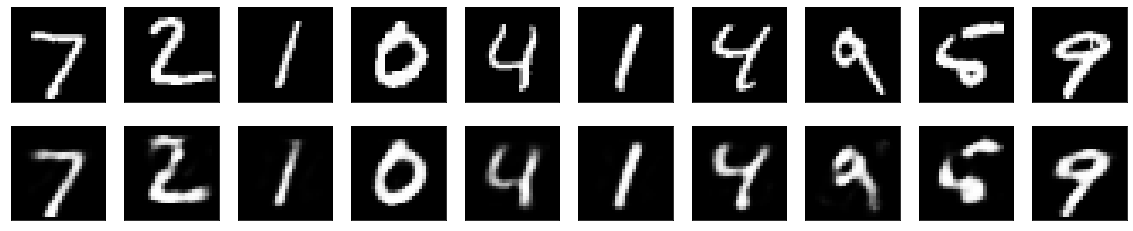

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
